In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/PataSST_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle
import pandas as pd
import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    
import matplotlib.path as mpath 
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=16)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Loading in SSTs from ERA5

In [10]:
%%time
patagonia_region_lon = [370, 521]
patagonia_region_lat = [500, 641] # 681 = 80°S, 641 = 70°S
ds_clim = xr.open_mfdataset('/g/data/rt52/era5/single-levels/reanalysis/' + 'sst/*/sst_era5_oper_sfc_*.nc').sst
ds_clim = ds_clim[:(8760*30),patagonia_region_lat[0]:patagonia_region_lat[1], patagonia_region_lon[0]:patagonia_region_lon[1]].groupby('time.month').mean('time')

year = ['2016', '2017']
for f in range(2):
    ds      = xr.open_mfdataset('/g/data/rt52/era5/single-levels/reanalysis/' + 'sst/'+year[f]+'/sst_era5_oper_sfc_*.nc').resample(time="1MS").mean(dim="time").sst
    ds      = ds[:,patagonia_region_lat[0]:patagonia_region_lat[1], patagonia_region_lon[0]:patagonia_region_lon[1]]
    if f == 0: ds_2016 = ds
    if f == 1: ds_2017 = ds
# Wall time: 14 s

CPU times: user 8.8 s, sys: 1.99 s, total: 10.8 s
Wall time: 10.9 s


In [ ]:
%%time
for y in range(2):
    if y == 0: ds_anom = ds_2016
    if y == 1: ds_anom = ds_2017
    print('Creating figure for '+year[y])
    plt.figure(figsize=(16,9))
    for f in range(12):
        ax1 = plt.subplot(3,4,f+1)
        plt.title('ERA5 SSTa '+ str(ds_anom.time[f])[36:43]); ax1.set_facecolor('k')
        (ds_anom[f,:,:]-ds_clim[f,:,:]).plot(levels=np.linspace(-3,3,21))
    # --- saving as 300 dpi .PNG image in specified folder -------------------------------------------------------- #
    plt.savefig(save + 'Monthly_SST_anoms_for_year_'+year[y],                          #
                dpi=300, facecolor='w',edgecolor='w', orientation='landscape', papertype=None, format=None,         #
                transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)                              #
    # --- end of script ------------------------------------------------------------------------------------------- # 
# Wall time: 9min 49s

Creating figure for 2016
Creating figure for 2017


### Making a spaghetti plot of SSTs in the Patagonian region

In [4]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# create custom color bar which I use to colour each line in the plot slightly more red
n_lines = 80
time = np.linspace(1,12,12)
c = np.arange(1, n_lines + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cm.cm.dense_r)
cmap.set_array([])


# only select the small region (51-55°S and 70-60°W)
patagonia_region_lon = [440, 481]
patagonia_region_lat = [564, 581] # 681 = 80°S, 641 = 70°S, 621 = 65°S, 560 = 50°S, 581 = 55°S

ds_clim = xr.open_mfdataset('/g/data/rt52/era5/single-levels/reanalysis/' + 'sst/*/sst_era5_oper_sfc_*.nc').sst
ds_clim = ds_clim[:(8760*30),patagonia_region_lat[0]:patagonia_region_lat[1], patagonia_region_lon[0]:patagonia_region_lon[1]].groupby('time.month').mean('time')
ds_clim = ds_clim.mean(['latitude', 'longitude']).load()
# wall time: 

2025-06-18 18:27:25,971 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.27 GiB -- Worker memory limit: 15.70 GiB
2025-06-18 18:27:26,056 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.51 GiB -- Worker memory limit: 15.70 GiB
2025-06-18 18:27:26,155 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

CPU times: user 43 s, sys: 14.3 s, total: 57.3 s
Wall time: 3min 44s


Year 1940 done
Year 1941 done
Year 1942 done
Year 1943 done
Year 1944 done
Year 1945 done
Year 1946 done
Year 1947 done
Year 1948 done
Year 1949 done
Year 1950 done
Year 1951 done
Year 1952 done
Year 1953 done
Year 1954 done
Year 1955 done
Year 1956 done
Year 1957 done
Year 1958 done
Year 1959 done
Year 1960 done
Year 1961 done
Year 1962 done
Year 1963 done
Year 1964 done
Year 1965 done
Year 1966 done
Year 1967 done
Year 1968 done
Year 1969 done
Year 1970 done
Year 1971 done
Year 1972 done
Year 1973 done
Year 1974 done
Year 1975 done
Year 1976 done
Year 1977 done
Year 1978 done
Year 1979 done
Year 1980 done
Year 1981 done
Year 1982 done
Year 1983 done
Year 1984 done
Year 1985 done
Year 1986 done
Year 1987 done
Year 1988 done
Year 1989 done
Year 1990 done
Year 1991 done
Year 1992 done
Year 1993 done
Year 1994 done
Year 1995 done
Year 1996 done
Year 1997 done
Year 1998 done
Year 1999 done
Year 2000 done
Year 2001 done
Year 2002 done
Year 2003 done
Year 2004 done
Year 2005 done
Year 2006 

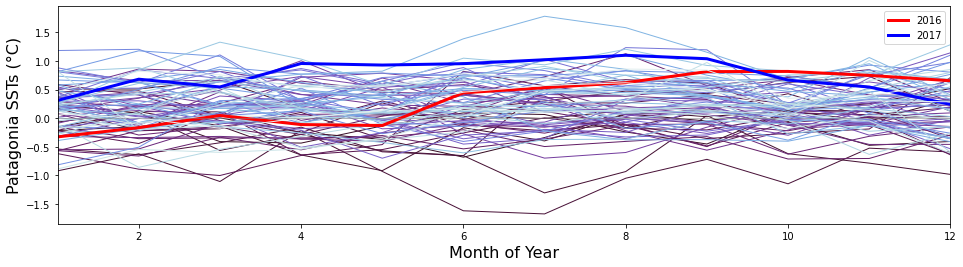

In [5]:
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cm.cm.dense_r)
plt.figure(figsize=(16,4))
for year in range(1940, 2020):
    ds = xr.open_mfdataset('/g/data/rt52/era5/single-levels/reanalysis/' + 'sst/'+str(year)+'/sst_era5_oper_sfc_*.nc').sst
    ds = ds[:,patagonia_region_lat[0]:patagonia_region_lat[1], patagonia_region_lon[0]:patagonia_region_lon[1]].resample(time="1MS").mean(dim="time")
    ds = ds.mean(['latitude', 'longitude']).load()

    if year != 2016 or 2017: plt.plot(time, ds.values-ds_clim.values, lw=1, c=cmap.to_rgba(year-1940 + 1))
    if year == 2016: plt.plot(time, ds.values-ds_clim.values, lw=3, c='red', label=str(year))
    if year == 2017: plt.plot(time, ds.values-ds_clim.values, lw=3, c='blue', label=str(year))
    print('Year ' + str(year) + ' done')
plt.xlabel('Month of Year', fontsize=16), plt.ylabel('Patagonia SSTs (°C)', fontsize=16); plt.legend(); plt.xlim([1,12])
plt.axhline(0, c='grey', lw=.5)
# plotting takes 17.7 s

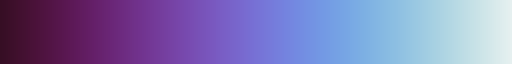

In [27]:
cm.cm.dense_r

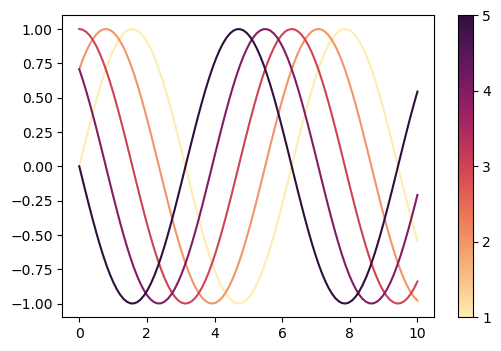

In [20]:


fig, ax = plt.subplots(dpi=100)
for i, yi in enumerate(y.T):
    ax.plot(x, yi, c=cmap.to_rgba(i + 1))

plt.show();

In [ ]:
year = ['2016', '2017']
for f in range(2):
    ds      = xr.open_mfdataset('/g/data/rt52/era5/single-levels/reanalysis/' + 'sst/'+year[f]+'/sst_era5_oper_sfc_*.nc').resample(time="1MS").mean(dim="time").sst
    ds      = ds[:,patagonia_region_lat[0]:patagonia_region_lat[1], patagonia_region_lon[0]:patagonia_region_lon[1]].mean(['latitude', 'longitude'])
    if f == 0: ds_2016 = ds
    if f == 1: ds_2017 = ds

In [ ]:
time = np.linspace(1,12,12)
plt.plot(time, ds_clim.values)

2025-05-23 07:40:58,796 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.04 GiB -- Worker memory limit: 15.70 GiB
2025-05-23 07:40:58,866 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.07 GiB -- Worker memory limit: 15.70 GiB
2025-05-23 07:40:59,389 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/colorama/initialise.py", line 18, in reset_all
    def reset_all():
KeyboardInterrupt
2025-05-23 07:34:33,897 - distributed.nanny - WARNING - Restarting worker


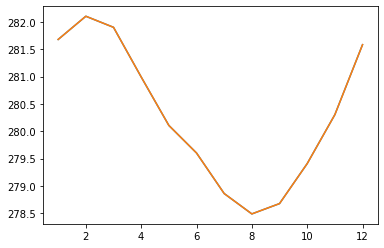

In [175]:
time = np.linspace(1,12,12)
#plt.plot(time, ds_clim.values, label='clim.')
plt.plot(time, ds_2016.values, label='2016')
plt.plot(time, ds_2016.values, label='2017')